In [16]:
import numpy as np
import pandas as pd

import os
import math
import time
import re
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df_features = pd.read_csv("/content/news_share_data_selected.csv")
df_features.sample(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
245,epic 5minute trailer shows wartorn world elder...,players looking join fray world elder scrolls ...,Friday,1.0,April,Social Media,0.0,0.0,0.0,1.0,...,5573.003,3225.939,0.000,0.501918,0.251587,0.069124,0.009217,0.55,0.2,3100.0
205,nest finds flaw smoke detector halts sales,silicon valley darling nest home appliance sta...,Thursday,0.0,April,Business,0.0,0.0,0.0,0.0,...,3573.086,2075.117,4950.000,0.500788,0.177496,0.042146,0.013410,1.00,0.5,865.0
459,paralyzed men move legs breakthrough spinal tr...,researchers university louisville intended stu...,Tuesday,0.0,April,Tech,0.0,0.0,0.0,0.0,...,4931.256,2909.970,1974.875,0.470451,0.187809,0.055577,0.017013,0.00,0.0,1900.0


In [18]:
df_features.shape

(516, 28)

In [19]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cleaned_title               516 non-null    object 
 1   cleaned_text                516 non-null    object 
 2   weekday                     515 non-null    object 
 3   is_weekend                  515 non-null    float64
 4   month                       515 non-null    object 
 5   cleaned_data_channel        515 non-null    object 
 6   Channel_Entertainment       515 non-null    float64
 7   Channel_Lifestyle           515 non-null    float64
 8   Channel_Others              515 non-null    float64
 9   Channel_Social Media        515 non-null    float64
 10  Channel_Tech                515 non-null    float64
 11  unique_tokens_rate          515 non-null    float64
 12  num_hrefs                   515 non-null    float64
 13  num_imgs                    515 non

In [20]:
df_features.columns

Index(['cleaned_title', 'cleaned_text', 'weekday', 'is_weekend', 'month',
       'cleaned_data_channel', 'Channel_Entertainment', 'Channel_Lifestyle',
       'Channel_Others', 'Channel_Social Media', 'Channel_Tech',
       'unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [21]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

In [22]:
print("\nDistribution (BEFORE outlier treatment):")
display(df_features[cols_to_treat].describe())


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.00000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,0.535332,11.295146,4.699029,1.252427,4.620599,7.248544,1118.06292,6098.265010,3282.295223,9059.200925,0.450955,0.106805,0.038850,0.018043,0.296718,0.058148,3209.038835
std,0.115535,12.745575,7.507759,4.202367,0.652108,1.845273,1179.52708,6981.236213,1392.621390,35072.038277,0.107520,0.089965,0.016495,0.010878,0.323069,0.276944,4974.663757
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000,3568.870000,1406.234000,0.000000,0.000000,-0.282220,0.000000,0.000000,0.000000,-1.000000,156.000000
25%,0.471853,4.000000,1.000000,0.000000,4.490062,6.000000,0.00000,3581.094000,2486.297500,1400.000000,0.399674,0.055115,0.028713,0.011800,0.000000,0.000000,1000.000000
50%,0.540761,8.000000,2.000000,0.000000,4.681818,7.000000,975.50000,4600.000000,2977.715000,2900.000000,0.456019,0.102175,0.037500,0.016461,0.227273,0.000000,1700.000000
75%,0.605449,14.000000,6.500000,1.000000,4.853155,9.000000,2166.00700,6609.296000,3761.262000,7250.000000,0.511413,0.162790,0.047325,0.022816,0.500000,0.136364,3100.000000
max,0.867925,122.000000,84.000000,51.000000,7.218430,10.000000,3581.09400,98700.000000,17604.270000,663600.000000,0.816667,0.489623,0.120805,0.103030,1.000000,1.000000,57200.000000


In [23]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_features, col):
    q1 = df_features[col].quantile(0.25)
    q3 = df_features[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_features[col] = df_features[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_features

for col in cols_to_treat:
    df_features = treat_outliers_iqr(df_features, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_features[cols_to_treat].describe())



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.00000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,0.539349,10.073786,4.020388,0.562136,4.674593,7.248544,1118.06292,5412.424755,3205.178329,4942.450381,0.454502,0.106817,0.038526,0.017587,0.296718,0.054071,2357.776699
std,0.099189,7.885266,4.728250,0.812729,0.277168,1.845273,1179.52708,2188.809268,1023.443957,5047.141314,0.091211,0.085309,0.015445,0.009202,0.323069,0.163799,1772.947703
min,0.271458,0.000000,0.000000,0.000000,3.945423,2.000000,0.00000,3568.870000,1406.234000,0.000000,0.232064,-0.106396,0.000793,0.000000,0.000000,-0.204546,156.000000
25%,0.471853,4.000000,1.000000,0.000000,4.490062,6.000000,0.00000,3581.094000,2486.297500,1400.000000,0.399674,0.055115,0.028713,0.011800,0.000000,0.000000,1000.000000
50%,0.540761,8.000000,2.000000,0.000000,4.681818,7.000000,975.50000,4600.000000,2977.715000,2900.000000,0.456019,0.102175,0.037500,0.016461,0.227273,0.000000,1700.000000
75%,0.605449,14.000000,6.500000,1.000000,4.853155,9.000000,2166.00700,6609.296000,3761.262000,7250.000000,0.511413,0.162790,0.047325,0.022816,0.500000,0.136364,3100.000000
max,0.805843,29.000000,14.750000,2.500000,5.397793,10.000000,3581.09400,11151.599000,5673.708750,16025.000000,0.679022,0.324300,0.075245,0.039340,1.000000,0.340910,6250.000000


In [24]:
print(df_features[cols_to_treat].dtypes)


unique_tokens_rate            float64
num_hrefs                     float64
num_imgs                      float64
num_videos                    float64
average_token_length          float64
num_keywords                  float64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                        float64
dtype: object


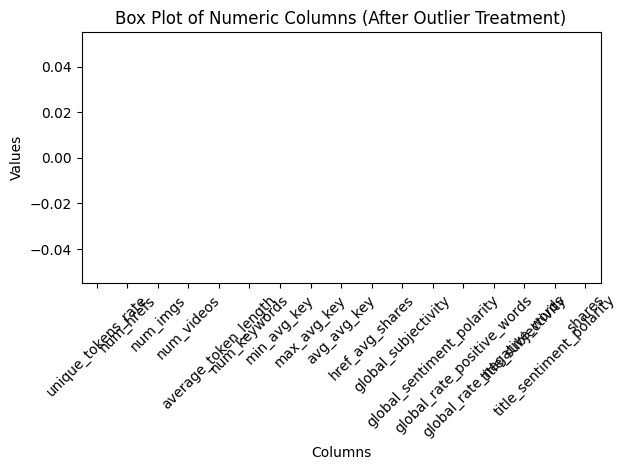

In [25]:
import matplotlib.pyplot as plt

plt.boxplot(df_features[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()


In [26]:

month_label_mapping = {'March': 3, 'April': 4}
week_label_mapping = {'Friday': 0,'Saturday': 1,'Sunday': 2,'Monday': 3, 'Tuesday': 4, 'Wednesday': 5,'Thursday' : 6}

df_features['month no'] = df_features['month'].map(month_label_mapping)
df_features['weekday no'] = df_features['weekday'].map(week_label_mapping)



In [27]:
df_features['avg shares daily'] = df_features.groupby('weekday')['shares'].transform('mean')
df_features['avg shares weekly'] = df_features.groupby('is_weekend')['shares'].transform('mean')
df_features['avg shares by channel'] = df_features.groupby('cleaned_data_channel')['shares'].transform('mean')


In [28]:
from nltk.tokenize import word_tokenize

def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

df_features['title_tokens'] = df_features['cleaned_title'].apply(count_tokens)
df_features['text_tokens'] = df_features['cleaned_text'].apply(count_tokens)

df_features[['cleaned_title', 'cleaned_text', 'title_tokens', 'text_tokens']]

,cleaned_title,cleaned_text,title_tokens,text_tokens
0,time youtube competitor,reported last week yahoo getting online video ...,3,102
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,8,54
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,8,239
3,african telecom proposes diverse emoticons,less week apple pledged make emoticons raciall...,5,141
4,google launch improved android camera app repo...,android users may soon see series new features...,8,148
...,...,...,...,...
511,facebooks messing around messenger way chat mo...,facebook acquired standalone messaging app wha...,7,175
512,facebook overhauls limits despised rightrail ads,facebook rolled last desktop redesign last mon...,6,176
513,facebook stock 5 sheryl sandberg vows run office,facebook stock jumped 5 early trading wednesda...,8,146
514,10 fresh apps fashion enthusiasts,hard beat experience admiring racks racks clot...,5,624


In [29]:
df_features.sample(4)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,title_subjectivity,title_sentiment_polarity,shares,month no,weekday no,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens
371,met mother releasing alternate ending dvd,warning spoilers ahead series finale ok quit b...,Monday,0.0,April,Entertainment,1.0,0.0,0.0,0.0,...,1.000000,0.000000,1000.0,4.0,3.0,2481.909091,2290.068966,2200.578947,6,148
463,report samsung outspent apple us handset adver...,samsung outspent apple 68 million advertising ...,Tuesday,0.0,April,Entertainment,1.0,0.0,0.0,0.0,...,0.333333,0.166667,1200.0,4.0,4.0,2308.387755,2290.068966,2200.578947,9,189
408,youtube files complaint turkish court ban,youtube lodged official complaint turkish cons...,Monday,0.0,April,Others,0.0,0.0,1.0,0.0,...,0.000000,0.000000,6250.0,4.0,3.0,2481.909091,2290.068966,2274.570588,6,166
80,women game developers means success animal cro...,video games exactly question games developers ...,Wednesday,0.0,April,Others,0.0,0.0,1.0,0.0,...,0.566667,-0.016670,946.0,4.0,5.0,2090.018349,2290.068966,2274.570588,9,315


<Axes: xlabel='title_tokens', ylabel='shares'>

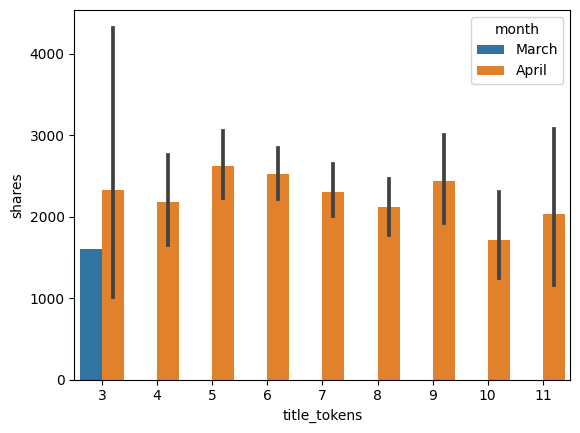

In [30]:
sns.barplot(data=df_features, x="title_tokens", y="shares", hue="month")

<Axes: xlabel='text_tokens', ylabel='shares'>

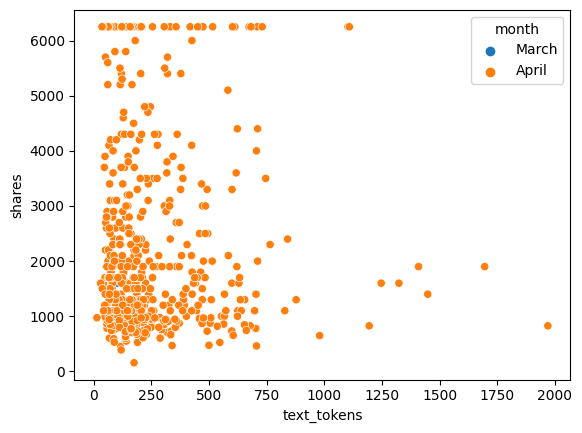

In [31]:
sns.scatterplot(df_features, x= 'text_tokens', y='shares', hue= 'month')

In [32]:
import re
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
import nltk
from nltk import pos_tag

from collections import Counter


In [36]:
def count_and_classify_pos_tags(text):
    words = word_tokenize(text)  # Tokenizing the text
    pos_tags = pos_tag(words)    # Applying POS tagging

    # Counts
    noun_count = 0
    verb_count = 0
    adjective_count = 0

    # Iterating through POS tags and classifying them
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            noun_count += 1
        elif tag.startswith('VB') or tag == 'RB' or tag == 'MD':  # Verbs and adverbs and modals
            verb_count += 1
        elif tag.startswith('JJ'):
            adjective_count += 1

    return {
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adjective_count': adjective_count
    }

In [37]:
df_features.head(3)

,cleaned_title,cleaned_text,weekday,is_weekend,month,cleaned_data_channel,Channel_Entertainment,Channel_Lifestyle,Channel_Others,Channel_Social Media,...,title_subjectivity,title_sentiment_polarity,shares,month no,weekday no,avg shares daily,avg shares weekly,avg shares by channel,title_tokens,text_tokens
0,time youtube competitor,reported last week yahoo getting online video ...,Monday,0.0,March,Business,0.0,0.0,0.0,0.0,...,0.25,0.25,1600.0,3.0,3.0,2481.909091,2290.068966,2199.626506,3,102
1,ultimate roundup 2014s biggest april fools day...,april fools marks day pranking goes corporate ...,Tuesday,0.0,April,Tech,0.0,0.0,0.0,0.0,...,0.00,0.00,1500.0,4.0,4.0,2308.387755,2290.068966,2628.378641,8,54
2,selfie one garish jacket red sox white house,2013 world series champion boston red sox visi...,Tuesday,0.0,April,Tech,0.0,0.0,0.0,0.0,...,0.00,0.00,1400.0,4.0,4.0,2308.387755,2290.068966,2628.378641,8,239


In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def Ngrams_extraction(descriptions):
    # Fill missing values with an empty string
    descriptions = descriptions.fillna('')

    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=7)
    X = vectorizer.fit_transform(descriptions)
    ngram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return ngram_df

ngram_title_df = Ngrams_extraction(df_features['cleaned_title'])
ngram_txt_df = Ngrams_extraction(df_features['cleaned_text'])


In [39]:
ngram_title_df.head(5)

,amazon fire,april fools,david letterman,fire tv,fools day,game thrones,need know
0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [40]:
ngram_txt_df.head(5)

,2014opens new,april 2014opens,fire tv,new window,new york,see also,windows xp
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,5,5,0,17,0,0,0
3,0,0,0,2,0,1,0
4,0,0,0,1,0,0,0


In [41]:
df_features.shape

(516, 35)